# Two-Dimensional Example

This is a quick tutorial to demonstrate basic usage of the G-Learn package.

### Import

Import the package using:

In [1]:
import glearn

Before starting, you can check the version of G-Learn, the available number of CPU processors, GPU devices, and memory usage of the current Python process via:

In [2]:
glearn.info()


glearn version  : 0.21.1
imate version   : 0.18.0
processor       : Intel(R) Core(TM) i5-2520M CPU @ 2.50GHz
num threads     : 4
gpu device      : not found
num gpu devices : 0
cuda version    : not found
nvidia driver   : not found
process memory  : 124.2 (Mb)



### Generate Points

We generate a set of 50 points randomly distributed in the domain $\mathcal{D} = [0, 1]^2$, where $80\%$ more points are concentrated in the sub-domain $[a=0.4, b=0.6]^2$ with a uniform distribution, and the rest of the points are spread uniformly elsewhere.

For simplicity, you can create such a set of points using the `glearn.sample_data` module.


In [3]:
from glearn import sample_data
x = sample_data.generate_points(num_points=100, dimension=2,
                                grid=False,a=[0.4, 0.4], b=[0.6, 0.6],
                                contrast=0.9, seed=42)

### Generate Noisy Data

On the set of points $\boldsymbol{x} = (x_1, \dots, x_d) \in \mathcal{D} \in \mathbb{R}^d$ (where $d=1$ as specified above), we define a stochastic function:

$$y(\boldsymbol{x}) = \sum_{i=1}^d \sin\left(\pi x_i \right) + \epsilon,$$

where $\epsilon$ is a random variable $\epsilon(x) \sim \mathcal{N}(0, \sigma_0^2)$ with a noise standard deviation of $\sigma_0 = 0.05$. 

You can generate the random data described above using the `glearn.sample_data` module.


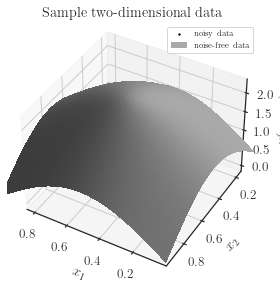

In [4]:
y_noisy = sample_data.generate_data(x, noise_magnitude=0.1, plot=True)

The figure above illustrates the noisy data (represented as dots) alongside the original function without noise (depicted as a solid curve). It's important to note that the majority of data points are concentrated within the sub-domain $[0.4, 0.6]^2$, while outside this interval, data points are sparsely distributed.

Later on, we will demonstrate accurate predictions within the concentrated sub-interval and less precise predictions outside of it.

### Stochastic Model for Noisy Data

We model the random data $z$ as:

$$y(x) = \mu(x) + \delta(x) + \epsilon(x),$$

where:

- $\mu(x)$ represents a deterministic mean function.
- $\delta(x)$ is a zero-mean stochastic function that will be determined later.
- $\epsilon(x)$ is a zero-mean stochastic function representing the input noise and characterized by the discrete covariance:

    $$\mathbb{E}[\epsilon(x), \epsilon(x')] = \sigma_0^2 \mathbf{I}$$
    
  where $\mathbf{I}$ is the identity matrix, and the hyperparameter $\sigma_0^2$ is the variance of the noise. It is assumed that the noise variance is not known.

### Design Matrix

We represent the deterministic mean function $\mu$ using the linear model $\mu(\boldsymbol{x}) = \boldsymbol{\phi}(x)^{\intercal} \boldsymbol{\beta}$, where $\boldsymbol{\phi}(x): \mathcal{D} \to \mathbb{R}^m$, and $\boldsymbol{\beta} \in \mathbb{R}^{m}$ are the parameters. On discrete points $\boldsymbol{x}$, the set of basis functions is discretized into the design matrix $\mathbf{X} \in \mathbb{R}^{n \times m}$:

$$X_{ij} = \phi_{j}(\boldsymbol{x}_i)$$

Other ways to construct the design matrix include using trigonometric functions, hyperbolic functions, user-defined custom functions, or a combination of all. In this case, only a fifth-order monomial is used:

$$\boldsymbol{\phi}(\boldsymbol{x}) = (1, x, \cdots, x^4)^{\intercal}.$$

Hence, in this context, $m = 5$.


### Prior for Parameter $\boldsymbol{\beta}$

A normal prior is prescribed for the unknown parameter $\boldsymbol{\beta}$ as follows:

$$p(\boldsymbol{\beta} | \sigma^2) \sim \mathcal{N}(\boldsymbol{b}, \sigma^2 \mathbf{B}),$$

where $\sigma^2  \mathbf{B} \in \mathbb{R}^{m \times m}$ represents the covariance of $\boldsymbol{\beta}$. The hyperparameter $\sigma^2$ denotes the variance of the regression and is not known.


In [7]:
# Mean of hyperparameter beta.
# The size of b should be m, the number of columns of design matrix X.
import numpy
b = numpy.zeros((21, ))

# Generate a random matrix B for covariance of beta.
# The shape of matrix B should be (m, m)
numpy.random.seed(0)
B = numpy.random.rand(b.size, b.size)

# Making sure the covariance matrix B positive-semidefinite
B = 1e+5 * B.T @ B

### Linear Model

The linear model with mean $\mu = \mathbf{X} \boldsymbol{\beta}$ can be created using the `glearn.mean.LinearModel` class:

In [8]:
# Create mean object using glearn.
mean = glearn.LinearModel(x, polynomial_degree=5, b=b, B=B)

### Kernels

The zero-mean stochastic function $\delta(x): \mathcal{D} \to \mathbb{R}$ is characterized by its covariance,

$$\mathbb{E}[\delta(x), \delta(x')] = k(x, x'|\boldsymbol{\alpha}).$$

The function $k: \mathcal{D} \times \mathcal{D} \times \mathbb{R}^d \to \mathbb{R}$ represents the correlation kernel and can be created using the `glearn.kernel` module. Various kernels available in this module include:

* `Matern()`
* `Exponential()`
* `SquareExponential()`
* `RationalQuadratic()`

In this example, we use the exponential kernel.


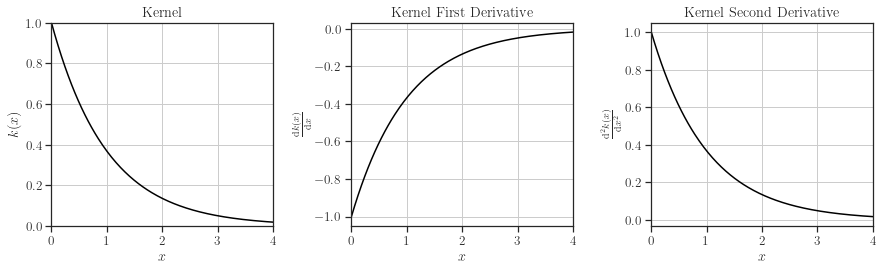

In [9]:
from glearn import kernels
kernel = kernels.Exponential()
kernel.plot()

### Scale Hyperparameter

The hyperparameters $\boldsymbol{\alpha} = (\alpha_1, \dots, \alpha_d) \in \mathbb{R}^d$ determines the scale of each spatial dimension. In our example, $d=1$. Scale can be either explicitly given if known, or can be characterized by a prior distribution $p(\boldsymbol{\alpha})$ using ``glearn.priors`` class. A list of available priors are

* ``Uniform``
* ``Cauchy``
* ``StudentT``
* ``InverseGamma``
* ``Normal``
* ``Erlang``
* ``BetaPrime``

Here, we use Cauchy prior. We also plot the prior and its frist and second derivative.

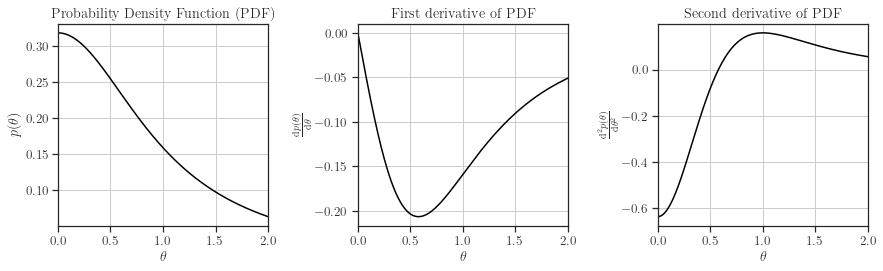

In [10]:
from glearn import priors
scale = priors.Cauchy()
scale.plot()

### Covariance

The covariance of the model is given by:

$$\boldsymbol{\Sigma}(\sigma^2, \sigma_0^2, \boldsymbol{\alpha}) = \sigma^2 \mathbf{K}(\boldsymbol{\alpha}) + \sigma_0^2 \mathbf{I},$$

where:

$$\mathbf{K}(\boldsymbol{\alpha}): \mathbb{R}^{d} \to \mathbb{R}^{n \times n},$$

and $\mathbf{I}$ represents the identity matrix.

An object of the above covariance model can be created using the `glearn.Covariance` class.

In [11]:
cov = glearn.Covariance(x, kernel=kernel, scale=scale)

### Gaussian Process

The Gaussian process is defined as:

$$z \sim \mathcal{GP}(\mu, \boldsymbol{\Sigma})$$

You can create the Gaussian process using the `glearn.GaussianProcess` class, which utilizes the mean and covariance objects.

In [12]:
gp = glearn.GaussianProcess(mean, cov)

### Training Hyperparameters

The hyperparameters $(\sigma, \sigma_0, \boldsymbol{\alpha})$ and the parameter $\boldsymbol{\beta}$ can be trained using the ``gp.train()`` function.

The type of profiling for the likelihood function can be set using the ``profile_hyperparam`` argument, which can take one of the following values:

* ``'none'``: no profiling
* ``'var'``: profiling on variance hyperparameter.
* ``'var_noise'``: profiling on both variance and noise hyperparameters.

The optimization method can be set using the ``optimization_method`` argument, which can be one of the following:

* ``'chandrupatla'``: requires Jacobian
* ``'brentq'``: requires Jacobian
* ``'Nelder-Mead'``: requires function
* ``'BFGS'``: requires function, Jacobian
* ``'CG'``: requires function, Jacobian
* ``'Newton-CG'``: requires function, Jacobian, Hessian
* ``'dogleg'``: requires function, Jacobian, Hessian
* ``'trust-exact'``: requires function, Jacobian, Hessian
* ``'trust-ncg'``: requires function, Jacobian, Hessian

The internal matrix algebra of this object can be set using the ``imate_method`` argument, which can take one of the following values:

* ``eigenvalue``: using the eigenvalue method.
* ``cholesky``: using the Cholesky method.
* ``hutchinson``: using the stochastic Hutchinson method.
* ``slq``: using the stochastic Lanczos quadrature method.

In this example, we use the Cholesky method.


In [13]:
profile_hyperparam = 'var'
optimization_method = 'Newton-CG'
imate_options = {'method': 'cholesky'}
hyperparam_guess = None
result = gp.train(y_noisy, profile_hyperparam=profile_hyperparam,
                  log_hyperparam=True, hyperparam_guess=hyperparam_guess,
                  optimization_method=optimization_method, tol=1e-6,
                  max_iter=1000, use_rel_error=True, imate_options=imate_options,
                  verbose=True, plot=False)


               Error                
itr   param  1   param  2   param  3
---   --------   --------   --------
001        inf        inf        inf
002   1.64e-01   4.29e-01   4.18e-01
003   3.28e-02   6.81e-01   6.70e-01
004   2.01e-03   3.56e-01   3.74e-01
005   1.29e-03   2.33e-01   2.89e-01
006   7.18e-04   1.28e-01   2.99e-01
007   2.28e-05   1.07e-02   7.00e-02
008   2.88e-05   1.60e-03   3.86e-03
009   2.26e-07   1.19e-04   1.30e-05
010   1.65e-07   1.01e-07   3.89e-10

                                Training Summary                                
       posterior/param                optimization              imate solver    
-----------------------------      -------------------      --------------------
posterior    +5.892157773e+01      method    Newton-CG      method      cholesky
eta          4.6442467478e+02      tol        1.00e-06      tol         1.00e-08
sigma        4.8346786357e-03      max iter       1000      interpolate    False
sigma0       1.0418981199e-01  

### Prediction

After training the hyperparameters, the ``gp`` object is ready to predict the data on new points. First, we create a set of $50^2$ test points $x^{\star}$ equally spaced in the domain $[0, 1]^2$.

In [14]:
# Generate test points
test_points = sample_data.generate_points(num_points=50, dimension=2, grid=True)

Note that the above step is unnecessary and is only used for the purpose of comparison with the prediction since we already know the exact function that generated the noisy data $z$ in the first place.

The posterior predictive distribution of the prediction $z^{\star}(x^{\star})$ takes the form:

$$z^{\star}(x^{\star}) \sim \mathcal{N}\left(\mu^{\star}(x^{\star}), \mathbf{\Sigma}^{\star \star}(x^{\star}, x'^{\star})\right)$$

where:

* $\mu^{\star}$ is the posterior predictive mean, and
* $\mathbf{\Sigma}^{\star \star}$ is the posterior predictive covariance between test points and themselves.

Prediction can be made using the ``gp.predict()`` function.



                               Prediction Summary                               
               process                                    config                
-------------------------------------      -------------------------------------
wall time (sec)               7.15e-1      num training points               100
proc time (sec)               1.95e+0      num test points                  2500
memory used (b)              66920448      compute covariance               True



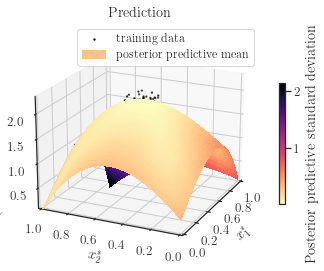

In [18]:
z_star_mean, z_star_cov = gp.predict(test_points, cov=True, plot=True,
                                     confidence_level=0.95, verbose=True)

By setting the boolean argument ``cov=False``, the predictive covariance is not computed, which enhances computational speed.

- When ``cov=True``, meaning that both $\mu^{\star}$ and $\mathbf{\Sigma}^{\star \star}$ are computed, the prediction process is $\mathcal{O}\left((n^{\star})^3\right)$ complex.
- In contrast, when ``cov=False`` to only compute $\mu^{\star}$, the prediction process is only $\mathcal{O}\left((n^{\star})^2\right)$ complex.

Furthermore, when ``cov=False``, once the first prediction on a set of test points $\left\{ x_i^{\star} \right\}_{n^{\star}}$ is made, the future calls to the ``predict()`` function are of order $\mathcal{O}(n^{\star})$, even when applied to a different set of test points. This is because the ``gp`` object stores all internal computations that are independent of the test points.

In [19]:
z_star_mean = gp.predict(test_points, cov=False, verbose=True)


                               Prediction Summary                               
               process                                    config                
-------------------------------------      -------------------------------------
wall time (sec)               4.47e-2      num training points               100
proc time (sec)               1.10e-1      num test points                  2500
memory used (b)                     0      compute covariance              False

